# Imports and General Settings

In [6]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/device:GPU:0


# Data Augmentation

In [7]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ConvNet

## ConvNet Architecture

In [8]:
num_classes = 3

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
#             x = model_arch.max_pooling(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 2)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [14]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

random.seed(a=random_seed)

num_steps = 10000

# convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_data_aug_no_norm/"

convnet_checkpoint_path_base = "/data/jma/model/model_experiments/model_10_7/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

# kernel_sizes = [[10, 7, 3]] v1

kernel_sizes = [[10, 7]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["original_new_labels", "undersampled"]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, norm=False, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/original_new_labels/train/
/data/jma/model/model_experiments/model_10_7/original_new_labels/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/model_experiments/model_10_7/original_new_labels/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f031bf07710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (

INFO:tensorflow:global_step/sec: 4.06691
INFO:tensorflow:loss = 2.8407503e-05, step = 680 (4.917 sec)
INFO:tensorflow:global_step/sec: 5.49623
INFO:tensorflow:loss = 1.5124316e-06, step = 700 (3.639 sec)
INFO:tensorflow:global_step/sec: 5.99902
INFO:tensorflow:loss = 0.0, step = 720 (3.335 sec)
INFO:tensorflow:global_step/sec: 6.35587
INFO:tensorflow:loss = 4.470345e-08, step = 740 (3.146 sec)
INFO:tensorflow:global_step/sec: 6.38461
INFO:tensorflow:loss = 5.8705073e-06, step = 760 (3.133 sec)
INFO:tensorflow:global_step/sec: 6.0451
INFO:tensorflow:loss = 0.0, step = 780 (3.310 sec)
INFO:tensorflow:global_step/sec: 5.65615
INFO:tensorflow:loss = 1.4901158e-08, step = 800 (3.535 sec)
INFO:tensorflow:global_step/sec: 5.44175
INFO:tensorflow:loss = 5.215402e-08, step = 820 (3.675 sec)
INFO:tensorflow:Saving checkpoints for 833 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_f

INFO:tensorflow:loss = 4.8800985e-07, step = 1480 (6.170 sec)
INFO:tensorflow:global_step/sec: 6.63104
INFO:tensorflow:loss = 0.0, step = 1500 (3.017 sec)
INFO:tensorflow:global_step/sec: 5.77828
INFO:tensorflow:loss = 8.19563e-08, step = 1520 (3.462 sec)
INFO:tensorflow:global_step/sec: 5.55289
INFO:tensorflow:loss = 1.1287525e-06, step = 1540 (3.600 sec)
INFO:tensorflow:global_step/sec: 5.97577
INFO:tensorflow:loss = 0.0, step = 1560 (3.348 sec)
INFO:tensorflow:global_step/sec: 5.59194
INFO:tensorflow:loss = 2.5331877e-07, step = 1580 (3.575 sec)
INFO:tensorflow:global_step/sec: 5.80162
INFO:tensorflow:loss = 1.8253891e-07, step = 1600 (3.448 sec)
INFO:tensorflow:global_step/sec: 5.53932
INFO:tensorflow:loss = 3.7995885e-06, step = 1620 (3.614 sec)
INFO:tensorflow:Saving checkpoints for 1636 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting eva

INFO:tensorflow:global_step/sec: 7.45154
INFO:tensorflow:loss = 1.5012739e-06, step = 2300 (2.684 sec)
INFO:tensorflow:global_step/sec: 5.79431
INFO:tensorflow:loss = 1.00582675e-07, step = 2320 (3.450 sec)
INFO:tensorflow:global_step/sec: 5.39825
INFO:tensorflow:loss = 8.4563504e-07, step = 2340 (3.708 sec)
INFO:tensorflow:global_step/sec: 5.63617
INFO:tensorflow:loss = 1.095225e-06, step = 2360 (3.547 sec)
INFO:tensorflow:global_step/sec: 5.36572
INFO:tensorflow:loss = 3.2037332e-07, step = 2380 (3.727 sec)
INFO:tensorflow:global_step/sec: 5.59963
INFO:tensorflow:loss = 1.7881354e-07, step = 2400 (3.572 sec)
INFO:tensorflow:global_step/sec: 5.52882
INFO:tensorflow:loss = 3.762525e-07, step = 2420 (3.619 sec)
INFO:tensorflow:Saving checkpoints for 2437 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-12-23:35:14
INFO:tenso

INFO:tensorflow:global_step/sec: 8.12368
INFO:tensorflow:loss = 1.8626448e-08, step = 3100 (2.462 sec)
INFO:tensorflow:global_step/sec: 5.83523
INFO:tensorflow:loss = 7.376034e-07, step = 3120 (3.428 sec)
INFO:tensorflow:global_step/sec: 5.46628
INFO:tensorflow:loss = 4.097818e-08, step = 3140 (3.658 sec)
INFO:tensorflow:global_step/sec: 5.73656
INFO:tensorflow:loss = 5.2154036e-08, step = 3160 (3.487 sec)
INFO:tensorflow:global_step/sec: 5.48176
INFO:tensorflow:loss = 0.0, step = 3180 (3.652 sec)
INFO:tensorflow:global_step/sec: 5.78515
INFO:tensorflow:loss = 1.9184936e-06, step = 3200 (3.454 sec)
INFO:tensorflow:global_step/sec: 5.66056
INFO:tensorflow:loss = 7.227028e-07, step = 3220 (3.533 sec)
INFO:tensorflow:Saving checkpoints for 3241 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-12-23:37:44
INFO:tensorflow:Graph 

INFO:tensorflow:loss = 0.0, step = 3900 (2.547 sec)
INFO:tensorflow:global_step/sec: 5.47272
INFO:tensorflow:loss = 5.1781115e-07, step = 3920 (3.653 sec)
INFO:tensorflow:global_step/sec: 5.46532
INFO:tensorflow:loss = 6.7054515e-07, step = 3940 (3.661 sec)
INFO:tensorflow:global_step/sec: 5.67025
INFO:tensorflow:loss = 7.4505797e-09, step = 3960 (3.527 sec)
INFO:tensorflow:global_step/sec: 5.5718
INFO:tensorflow:loss = 3.1292302e-07, step = 3980 (3.589 sec)
INFO:tensorflow:global_step/sec: 5.68642
INFO:tensorflow:loss = 3.4645007e-07, step = 4000 (3.517 sec)
INFO:tensorflow:global_step/sec: 5.46906
INFO:tensorflow:loss = 2.9802308e-08, step = 4020 (3.658 sec)
INFO:tensorflow:Saving checkpoints for 4039 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-12-23:40:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 6.5192245e-07, step = 4700 (4.959 sec)
INFO:tensorflow:global_step/sec: 5.48857
INFO:tensorflow:loss = 2.6077027e-08, step = 4720 (3.642 sec)
INFO:tensorflow:global_step/sec: 6.40545
INFO:tensorflow:loss = 1.4901158e-08, step = 4740 (3.123 sec)
INFO:tensorflow:global_step/sec: 5.85888
INFO:tensorflow:loss = 0.0, step = 4760 (3.413 sec)
INFO:tensorflow:global_step/sec: 6.12205
INFO:tensorflow:loss = 0.0, step = 4780 (3.267 sec)
INFO:tensorflow:global_step/sec: 6.56907
INFO:tensorflow:loss = 2.2351738e-08, step = 4800 (3.045 sec)
INFO:tensorflow:global_step/sec: 6.02892
INFO:tensorflow:loss = 0.0, step = 4820 (3.317 sec)
INFO:tensorflow:global_step/sec: 5.96814
INFO:tensorflow:loss = 0.0, step = 4840 (3.351 sec)
INFO:tensorflow:Saving checkpoints for 4860 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08

INFO:tensorflow:global_step/sec: 3.85103
INFO:tensorflow:loss = 1.3783544e-07, step = 5540 (5.192 sec)
INFO:tensorflow:global_step/sec: 5.95911
INFO:tensorflow:loss = 1.6018731e-07, step = 5560 (3.356 sec)
INFO:tensorflow:global_step/sec: 6.01633
INFO:tensorflow:loss = 1.6391255e-07, step = 5580 (3.325 sec)
INFO:tensorflow:global_step/sec: 6.13073
INFO:tensorflow:loss = 1.2293434e-07, step = 5600 (3.262 sec)
INFO:tensorflow:global_step/sec: 5.49752
INFO:tensorflow:loss = 2.0116532e-07, step = 5620 (3.637 sec)
INFO:tensorflow:global_step/sec: 6.08095
INFO:tensorflow:loss = 4.5820912e-07, step = 5640 (3.290 sec)
INFO:tensorflow:global_step/sec: 5.8154
INFO:tensorflow:loss = 2.2351738e-08, step = 5660 (3.440 sec)
INFO:tensorflow:global_step/sec: 5.74218
INFO:tensorflow:loss = 1.4901158e-08, step = 5680 (3.480 sec)
INFO:tensorflow:Saving checkpoints for 5699 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6375: /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-6375
INFO:tensorflow:global_step/sec: 3.70852
INFO:tensorflow:loss = 2.9802308e-08, step = 6380 (5.390 sec)
INFO:tensorflow:global_step/sec: 6.86272
INFO:tensorflow:loss = 9.313214e-08, step = 6400 (2.915 sec)
INFO:tensorflow:global_step/sec: 6.24367
INFO:tensorflow:loss = 0.0, step = 6420 (3.204 sec)
INFO:tensorflow:global_step/sec: 5.92219
INFO:tensorflow:loss = 1.4901158e-08, step = 6440 (3.379 sec)
INFO:tensorflow:global_step/sec: 5.93449
INFO:tensorflow:loss = 7.078044e-08, step = 6460 (3.368 sec)
INFO:tensorflow:global_step/sec: 6.41815
INFO:tensorflow:loss = 8.5681556e-08, step = 6480 (3.117 sec)
INFO:tensorflow:global_step/sec: 6.60917
INFO:tensorflow:loss = 1.1548392e-07, step = 6500 (3.025 sec)
INFO:tensorflow:global_step/sec: 6.2995
INFO:tensorflow:loss = 1.3411032e-07, step = 6520 (3.175 sec)
INFO:tensorflow:global_step/sec: 6.41

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-12-23:49:49
INFO:tensorflow:Saving dict for global step 7226: accuracy = 0.67772514, global_step = 7226, loss = 7.867454
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7226: /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-7226
INFO:tensorflow:global_step/sec: 4.16409
INFO:tensorflow:loss = 3.7252892e-08, step = 7240 (4.802 sec)
INFO:tensorflow:global_step/sec: 5.63454
INFO:tensorflow:loss = 1.4528618e-07, step = 7260 (3.551 sec)
INFO:tensorflow:global_step/sec: 5.47853
INFO:tensorflow:loss = 8.940686e-08, step = 7280 (3.650 sec)
INFO:tensorflow:global_step/sec: 5.92038
INFO:tensorflow:loss = 0.0, step = 7300 (3.378 sec)
INFO:tensorflow:global_step/sec: 5.7954
INFO:tensorflow:loss = 2.2351735e-08, step = 7320 (3.452 sec)
INFO:tensorflow:global_step/sec: 5.9867
INFO:tensorflow:loss = 5.5879312e-08, step = 7340 (3.3

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-8065
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-12-23:52:19
INFO:tensorflow:Saving dict for global step 8065: accuracy = 0.67772514, global_step = 8065, loss = 7.8640924
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8065: /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-8065
INFO:tensorflow:global_step/sec: 3.86427
INFO:tensorflow:loss = 0.0, step = 8080 (5.175 sec)
INFO:tensorflow:global_step/sec: 6.00606
INFO:tensorflow:loss = 4.4703462e-08, step = 8100 (3.330 sec)
INFO:tensorflow:global_step/sec: 5.41376
INFO:tensorflow:loss = 1.7881352e-07, step = 8120 (3.694 sec)
INFO:tensorflow:global_step/sec: 5.88522
INFO:tensorflow:loss = 0.0, step = 8140 (3.398 sec)
INFO:tensorflow:global_step/sec: 5.8573
INFO

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-12-23:54:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-8905
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-12-23:54:49
INFO:tensorflow:Saving dict for global step 8905: accuracy = 0.67772514, global_step = 8905, loss = 7.861019
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8905: /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-8905
INFO:tensorflow:global_step/sec: 4.02411
INFO:tensorflow:loss = 7.078047e-08, step = 8920 (4.970 sec)
INFO:tensorflow:global_step/sec: 6.65157
INFO:tensorflow:loss = 6.70552e-08, step = 8940 (3.007 sec)
INFO:tensorflow:global_step/sec: 5.87121
INFO:tensorflow:loss = 4.470345e-08, step = 8960 

INFO:tensorflow:loss = 1.8626448e-08, step = 9740 (3.350 sec)
INFO:tensorflow:Saving checkpoints for 9760 into /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-12-23:57:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-9760
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-12-23:57:20
INFO:tensorflow:Saving dict for global step 9760: accuracy = 0.67772514, global_step = 9760, loss = 7.857965
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9760: /data/jma/model/model_experiments/model_10_7/original_new_labels/model.ckpt-9760
INFO:tensorflow:global_step/sec: 3.34824
INFO:tensorflow:loss = 0.0, step = 9760 (5.973 sec)
INFO:tensorf

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-333
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-12-23:59:08
INFO:tensorflow:Saving dict for global step 333: accuracy = 0.67114097, global_step = 333, loss = 11.102046
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 333: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-333
INFO:tensorflow:global_step/sec: 4.18661
INFO:tensorflow:loss = 2.100993e-06, step = 340 (4.775 sec)
INFO:tensorflow:global_step/sec: 5.8556
INFO:tensorflow:loss = 1.7881354e-07, step = 360 (3.416 sec)
INFO:tensorflow:global_step/sec: 5.48465
INFO:tensorflow:loss = 1.8347282, step = 380 (3.646 sec)
INFO:tensorflow:global_step/sec: 5.78021
INFO:tensorflow:loss = 0.19404693, step = 400 (3.462 sec)
INFO:tensorflow:global_step/sec: 5.78379
INFO:tensorflow

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:01:38
INFO:tensorflow:Saving dict for global step 1160: accuracy = 0.61744964, global_step = 1160, loss = 9.787153
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1160: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-1160
INFO:tensorflow:global_step/sec: 3.70083
INFO:tensorflow:loss = 5.5879315e-08, step = 1160 (5.402 sec)
INFO:tensorflow:global_step/sec: 7.30175
INFO:tensorflow:loss = 5.5203927e-06, step = 1180 (2.739 sec)
INFO:tensorflow:global_step/sec: 5.87607
INFO:tensorflow:loss = 5.5879323e-08, step = 1200 (3.404 sec)
INFO:tensorflow:global_step/sec: 6.21184
INFO:tensorflow:loss = 6.2741727e-09, step = 1220 (3.219 sec)
INFO:tensorflow:global_step/sec: 5.63925
INFO:tensorflow:loss = 0.0, step = 1240 (3.547 sec)
INFO:tensorflow:global_step/sec: 6.40541
INFO:tensorflow:loss = 0.0, step = 1260 (3.123 sec)
INFO:t

INFO:tensorflow:loss = 1.7881342e-07, step = 2040 (3.323 sec)
INFO:tensorflow:global_step/sec: 5.77308
INFO:tensorflow:loss = 0.0, step = 2060 (3.463 sec)
INFO:tensorflow:global_step/sec: 5.72762
INFO:tensorflow:loss = 4.731083e-07, step = 2080 (3.492 sec)
INFO:tensorflow:global_step/sec: 5.64792
INFO:tensorflow:loss = 3.72529e-09, step = 2100 (3.547 sec)
INFO:tensorflow:global_step/sec: 5.86498
INFO:tensorflow:loss = 0.0, step = 2120 (3.403 sec)
INFO:tensorflow:global_step/sec: 6.29686
INFO:tensorflow:loss = 1.4901158e-08, step = 2140 (3.176 sec)
INFO:tensorflow:global_step/sec: 5.98139
INFO:tensorflow:loss = 1.1101168e-06, step = 2160 (3.345 sec)
INFO:tensorflow:Saving checkpoints for 2178 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:04:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /

INFO:tensorflow:loss = 0.0, step = 3000 (3.386 sec)
INFO:tensorflow:global_step/sec: 5.64835
INFO:tensorflow:loss = 3.72529e-09, step = 3020 (3.540 sec)
INFO:tensorflow:Saving checkpoints for 3029 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:07:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-3029
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:07:09
INFO:tensorflow:Saving dict for global step 3029: accuracy = 0.61744964, global_step = 3029, loss = 9.774076
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3029: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-3029
INFO:tensorflow:global_step/sec: 4.

INFO:tensorflow:loss = 3.725289e-08, step = 3840 (3.613 sec)
INFO:tensorflow:global_step/sec: 6.00144
INFO:tensorflow:loss = 6.2741727e-09, step = 3860 (3.331 sec)
INFO:tensorflow:Saving checkpoints for 3873 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:09:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-3873
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:09:39
INFO:tensorflow:Saving dict for global step 3873: accuracy = 0.62416106, global_step = 3873, loss = 9.769673
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3873: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-3873
INFO:tensorflow:global_s

INFO:tensorflow:loss = 5.5879305e-08, step = 4680 (3.771 sec)
INFO:tensorflow:global_step/sec: 5.66763
INFO:tensorflow:loss = 0.0, step = 4700 (3.528 sec)
INFO:tensorflow:Saving checkpoints for 4711 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:12:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-4711
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:12:10
INFO:tensorflow:Saving dict for global step 4711: accuracy = 0.62416106, global_step = 4711, loss = 9.765529
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4711: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-4711
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 1.8626446e-08, step = 5520 (3.400 sec)
INFO:tensorflow:global_step/sec: 5.69639
INFO:tensorflow:loss = 1.7881342e-07, step = 5540 (3.510 sec)
INFO:tensorflow:Saving checkpoints for 5544 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:14:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-5544
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:14:41
INFO:tensorflow:Saving dict for global step 5544: accuracy = 0.62416106, global_step = 5544, loss = 9.761572
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5544: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-5544
INFO:tensorflow:global_

INFO:tensorflow:loss = 7.4505797e-09, step = 6360 (3.481 sec)
INFO:tensorflow:global_step/sec: 5.5886
INFO:tensorflow:loss = 3.3527595e-08, step = 6380 (3.578 sec)
INFO:tensorflow:Saving checkpoints for 6388 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:17:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-6388
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:17:11
INFO:tensorflow:Saving dict for global step 6388: accuracy = 0.62416106, global_step = 6388, loss = 9.75766
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6388: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-6388
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.0, step = 7200 (3.518 sec)
INFO:tensorflow:global_step/sec: 5.58708
INFO:tensorflow:loss = 4.470345e-08, step = 7220 (3.581 sec)
INFO:tensorflow:Saving checkpoints for 7229 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:19:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-7229
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:19:42
INFO:tensorflow:Saving dict for global step 7229: accuracy = 0.62416106, global_step = 7229, loss = 9.753726
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7229: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-7229
INFO:tensorflow:global_step/sec: 4

INFO:tensorflow:global_step/sec: 6.21971
INFO:tensorflow:loss = 0.0, step = 8060 (3.215 sec)
INFO:tensorflow:Saving checkpoints for 8080 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:22:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-8080
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:22:12
INFO:tensorflow:Saving dict for global step 8080: accuracy = 0.62416106, global_step = 8080, loss = 9.749711
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8080: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-8080
INFO:tensorflow:global_step/sec: 3.87649
INFO:tensorflow:loss = 7.4505797e-09, step = 8080 (5.1

INFO:tensorflow:global_step/sec: 5.63532
INFO:tensorflow:loss = 2.2351735e-08, step = 8900 (3.548 sec)
INFO:tensorflow:Saving checkpoints for 8914 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:24:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-8914
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:24:42
INFO:tensorflow:Saving dict for global step 8914: accuracy = 0.62416106, global_step = 8914, loss = 9.745951
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8914: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-8914
INFO:tensorflow:global_step/sec: 4.30583
INFO:tensorflow:loss = 0.0, step = 8920 (4.6

INFO:tensorflow:global_step/sec: 6.10813
INFO:tensorflow:loss = 7.45058e-09, step = 9740 (3.276 sec)
INFO:tensorflow:Saving checkpoints for 9749 into /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-13-00:27:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-9749
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-13-00:27:13
INFO:tensorflow:Saving dict for global step 9749: accuracy = 0.62416106, global_step = 9749, loss = 9.742174
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9749: /data/jma/model/model_experiments/model_10_7/undersampled/model.ckpt-9749
INFO:tensorflow:global_step/sec: 4.23606
INFO:tensorflow:loss = 1.8626446e-08, step = 9

## Evaluation

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_norm_no_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = convnet_checkpoint_path_base + "original_new_labels/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd5fe1d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Call

# Metrics

## Metric Utility Functions

In [9]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

print(eval_paths[:20])


['data/generated_splits/undersampled/eval/1/IM-0025-0022-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0048-0009-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0052-0049-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0034-0016-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0011-0017-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0050-0004-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0007-0012-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0002-0035-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0019-0009-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0017-0017-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0025-0020-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0007-0010-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0024-0011-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0040-0017-0001.dcm.png', 'data

## Confusion Matrices

./data/generated_splits/original_initial_labels/eval/
['data/generated_splits/original_initial_labels/eval/1/819be44b-5472-47e7-9fc8-80489088bca2.png', 'data/generated_splits/original_initial_labels/eval/1/417cf10a-6e70-4303-ad89-a8de47c9705d.png', 'data/generated_splits/original_initial_labels/eval/1/1da728f3-05ac-444c-9361-a5fc526ea804.png', 'data/generated_splits/original_initial_labels/eval/1/b1772a43-a662-4d78-8f78-717c1dd97dd2.png', 'data/generated_splits/original_initial_labels/eval/1/fbcef938-a010-4dc6-82bb-65f9094c5202.png']
/data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/original_initial_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterat

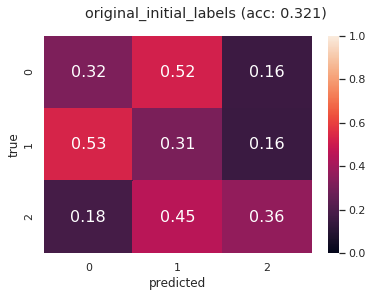

./data/generated_splits/original_new_labels/eval/
['data/generated_splits/original_new_labels/eval/1/IM-0071-0019-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0025-0022-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0028-0011-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0042-0021-0001.dcm.png', 'data/generated_splits/original_new_labels/eval/1/IM-0037-0020-0001.dcm.png']
/data/jma/model/dataset_experiments/with_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_step

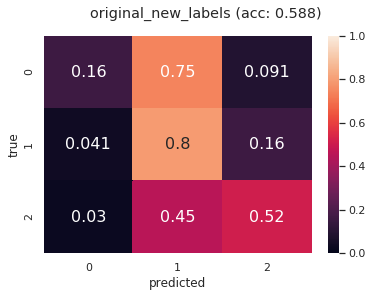

./data/generated_splits/train_set_balanced/eval/
['data/generated_splits/train_set_balanced/eval/1/IM-0040-0029-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0052-0028-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0019-0003-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0063-0024-0001.dcm.png', 'data/generated_splits/train_set_balanced/eval/1/IM-0051-0026-0001.dcm.png']
/data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/train_set_balanced/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100,

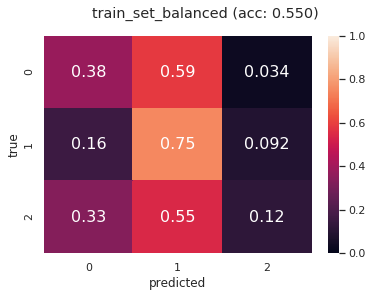

./data/generated_splits/whole_set_balanced/eval/
['data/generated_splits/whole_set_balanced/eval/1/IM-0049-0016-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0026-0015-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0031-0005-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0034-0016-0001.dcm.png', 'data/generated_splits/whole_set_balanced/eval/1/IM-0032-0030-0001.dcm.png']
/data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/whole_set_balanced/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100,

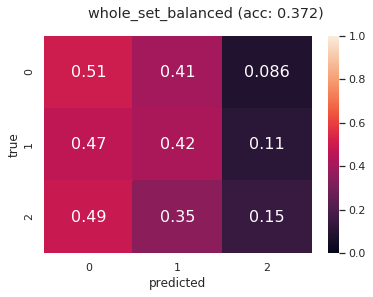

./data/generated_splits/undersampled/eval/
['data/generated_splits/undersampled/eval/1/IM-0025-0022-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0048-0009-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0052-0049-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0034-0016-0001.dcm.png', 'data/generated_splits/undersampled/eval/1/IM-0011-0017-0001.dcm.png']
/data/jma/model/dataset_experiments/with_data_aug/undersampled/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/with_data_aug/undersampled/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, 

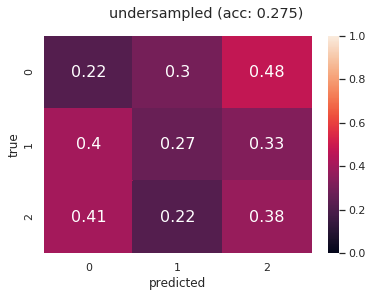

In [13]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/with_data_aug/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["original_initial_labels", "original_new_labels", "train_set_balanced", "whole_set_balanced", "undersampled"]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:
                
                tf.logging.set_verbosity(tf.logging.INFO)
                
                eval_root = dataset_root + dt_set + "/eval/"
                   
                print(eval_root)
            
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                print(eval_paths[:5])
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set +"/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                            num_channels=filter_size)
                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predicted_labels = list(values)

                
                accuracy = sklearn.metrics.accuracy_score(original_labels, predicted_labels)
                
                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(3), range(3))
                #plt.figure(figsize = (10,7))

                sns.set(font_scale=1)#for label size
                plt.suptitle(dt_set + " (acc: " + str('%.3f'%(accuracy)) + ")")
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1.0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()
        



## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


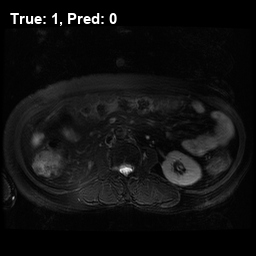

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    